170104016_exp_01

In [ ]:
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from matplotlib import pyplot as plt
from numpy import mean
import os
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/softcom_assignment2/Dataset A/training-a'

In [ ]:
a_csv = pd.read_csv('/content/gdrive/MyDrive/softcom_assignment2/Dataset A/training-a.csv')
a_csv.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [ ]:
a_csv = a_csv.drop(columns=['original filename', 'scanid',
       'database name original', 'contributing team', 'database name'])
a_csv.iloc[:10, 0:]

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
5,a00005.png,4
6,a00006.png,3
7,a00007.png,0
8,a00008.png,4
9,a00009.png,9


In [ ]:
label_csv = a_csv 

In [ ]:
import torch
from torch.utils.data import Dataset

class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
])

train_data  = Dataset(label_csv, path, train_transform)
test_data = Dataset(label_csv, path, test_transform)

print("Trainig Samples: ",len(train_data))

Trainig Samples:  19702


In [ ]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(train_data, test_size = 0.2)
print(len(train_dataset))
print(len(test_dataset))

15761
3941
15761
3941


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 20
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 200
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()
 
         
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_6 = nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2969279289245605. Accuracy: 10.073585384420198
Iteration: 1000. Loss: 2.307504653930664. Accuracy: 10.073585384420198
Iteration: 1500. Loss: 2.305015802383423. Accuracy: 9.515351433646282
Iteration: 2000. Loss: 2.299898386001587. Accuracy: 9.515351433646282
Iteration: 2500. Loss: 2.3024308681488037. Accuracy: 10.073585384420198
Iteration: 3000. Loss: 2.299345016479492. Accuracy: 9.591474245115453
Iteration: 3500. Loss: 2.302377462387085. Accuracy: 9.540725704136007
Iteration: 4000. Loss: 2.3033459186553955. Accuracy: 9.591474245115453
Iteration: 4500. Loss: 2.309556484222412. Accuracy: 9.312357269728496
Iteration: 5000. Loss: 2.303438663482666. Accuracy: 9.845216950012688
Iteration: 5500. Loss: 2.3066980838775635. Accuracy: 9.540725704136007
Iteration: 6000. Loss: 2.302457571029663. Accuracy: 9.591474245115453
Iteration: 6500. Loss: 2.2962334156036377. Accuracy: 9.591474245115453
Iteration: 7000. Loss: 2.301640272140503. Accuracy: 9.540725704136007
Iteration: 75

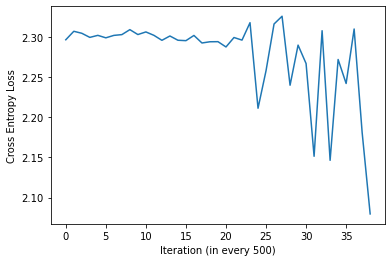

In [ ]:
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

170104016_exp_02_1

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 100
num_iters = 30000
input_dim = 28*28 # num_features = 784
num_hidden = 200
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()
 
       
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_5(out)
 
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3041999340057373. Accuracy: 9.540725704136007
Iteration: 1000. Loss: 2.302365303039551. Accuracy: 9.540725704136007
Iteration: 1500. Loss: 2.3049368858337402. Accuracy: 10.149708195889367
Iteration: 2000. Loss: 2.3010826110839844. Accuracy: 9.540725704136007
Iteration: 2500. Loss: 2.3004250526428223. Accuracy: 9.819842679522964
Iteration: 3000. Loss: 2.2998318672180176. Accuracy: 11.49454453184471
Iteration: 3500. Loss: 2.299253463745117. Accuracy: 9.515351433646282
Iteration: 4000. Loss: 2.2873411178588867. Accuracy: 10.68256787617356
Iteration: 4500. Loss: 2.2994730472564697. Accuracy: 10.225831007358538
Iteration: 5000. Loss: 2.298243522644043. Accuracy: 10.124333925399645
Iteration: 5500. Loss: 2.312063455581665. Accuracy: 9.743719868053793
Iteration: 6000. Loss: 2.2279181480407715. Accuracy: 13.245369195635625
Iteration: 6500. Loss: 2.305143356323242. Accuracy: 9.921339761481857
Iteration: 7000. Loss: 2.2282636165618896. Accuracy: 21.238264399898505
Iterati

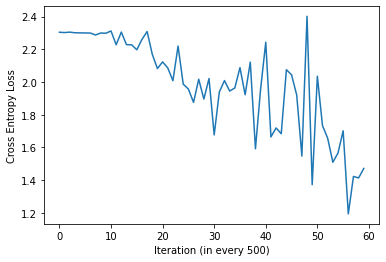

In [ ]:
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

170104016_exp_02_2

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 150
num_iters = 50000
input_dim = 28*28 # num_features = 784
num_hidden = 200
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_4(out)
 
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.3027467727661133. Accuracy: 11.190053285968029
Iteration: 1000. Loss: 2.3022620677948. Accuracy: 9.540725704136007
Iteration: 1500. Loss: 2.2946324348449707. Accuracy: 12.205024105556966
Iteration: 2000. Loss: 2.2804932594299316. Accuracy: 10.403450900786602
Iteration: 2500. Loss: 2.2709929943084717. Accuracy: 16.01116467901548
Iteration: 3000. Loss: 2.2305400371551514. Accuracy: 17.711240801826946
Iteration: 3500. Loss: 2.286752462387085. Accuracy: 12.99162649073839
Iteration: 4000. Loss: 2.3057565689086914. Accuracy: 24.917533620908397
Iteration: 4500. Loss: 2.231379747390747. Accuracy: 12.864755138289775
Iteration: 5000. Loss: 2.2351791858673096. Accuracy: 20.98452169500127
Iteration: 5500. Loss: 2.156486749649048. Accuracy: 13.042375031717839
Iteration: 6000. Loss: 2.1609084606170654. Accuracy: 20.4770362852068
Iteration: 6500. Loss: 2.227597951889038. Accuracy: 14.640954072570414
Iteration: 7000. Loss: 2.090390205383301. Accuracy: 30.1192590713017
Iteration

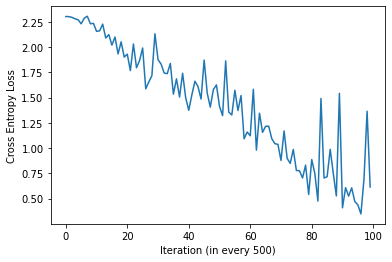

In [ ]:
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

170104016_exp_02_3

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 200
num_iters = 70000
input_dim = 28*28 # num_features = 784
num_hidden = 200
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 


In [ ]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
 
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iteration_loss = []

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2997689247131348. Accuracy: 9.997462572951028
Iteration: 1000. Loss: 2.286375045776367. Accuracy: 15.35143364628267
Iteration: 1500. Loss: 2.263052225112915. Accuracy: 11.139304744988582
Iteration: 2000. Loss: 2.218529462814331. Accuracy: 20.32479066226846
Iteration: 2500. Loss: 2.2076454162597656. Accuracy: 16.18878457244354
Iteration: 3000. Loss: 2.260531425476074. Accuracy: 22.151738137528547
Iteration: 3500. Loss: 2.1436023712158203. Accuracy: 24.30855112915504
Iteration: 4000. Loss: 2.376915693283081. Accuracy: 18.599340268967268
Iteration: 4500. Loss: 2.105703353881836. Accuracy: 23.7249429078914
Iteration: 5000. Loss: 2.028651714324951. Accuracy: 28.368434407510783
Iteration: 5500. Loss: 1.9380358457565308. Accuracy: 30.95660999746257
Iteration: 6000. Loss: 2.25069522857666. Accuracy: 36.05683836589698
Iteration: 6500. Loss: 2.2493276596069336. Accuracy: 16.0365389495052
Iteration: 7000. Loss: 2.083634376525879. Accuracy: 17.761989342806395
Iteration: 750

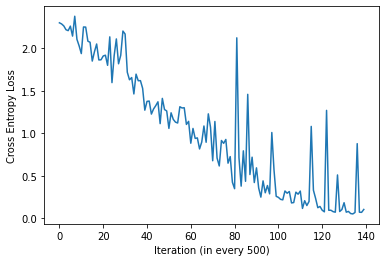

In [ ]:
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/softcom_assignment2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
save_model = True

if save_model is True:
   
    torch.save(model.state_dict(), root_path + 'Experiment1.pkl') 